In [1]:
from matplotlib.pylab import*

from scipy.interpolate import griddata
from matplotlib import cm
import pandas as pd
from time import perf_counter
from sympy import*
import warnings
warnings.filterwarnings('ignore')

from Inputs import*
    
order = array([4])        # polynomial order
Nv = array([8,16,24])
kstages = 3
cfl = 0.25
dt = 1e-2
Tfinal = 0.01
iplot = False            # plot the solution
iconverg = False

time_method = "BDF2"      # IRK, BDF2 or BDF3
integration_type = 1      # % = 1 is inexact and = 2 is exact
icase = 2                 # select icase: 1,2,3,4

alpha = 1              
beta = 0#-1/2                  # Dirichlet: alpha = 0, beta = 1
                               # Neumann: alpha = 1, beta = 0
                               # Robin: alpha = 1, beta != 0

x_boundary = [4,4]    # Bottom and Top (x = -1 and x = +1)
y_boundary = [4,4]    # Left and Right (y = -1 and x = +1)

Visualisation2(order,Nv,time_method,kstages,integration_type,icase,Tfinal,alpha,beta,x_boundary,y_boundary)

Problem: Diffusion
Domain: [0, 6.283185307179586]
Diffusivity: 1.0
Boundary conditions:  Neumann & 

N = 4, nel = 64, Np = 1089
	dt = 2.9412e-04
	Number of time steps = 34
	l2_norm: 0.0004418877682730713
	walltime: 2.4940441250000003
N = 4, nel = 256, Np = 4225
	dt = 1.9881e-05
	Number of time steps = 503
	l2_norm: 2.9848544491177185e-05
	walltime: 18.524195210000002
N = 4, nel = 576, Np = 9409
	dt = 4.0128e-06
	Number of time steps = 2492
	l2_norm: 6.024155210862394e-06
	walltime: 160.57418034900002

End simulation


In [2]:
import pandas 

idx = pandas.IndexSlice

# Integration  : 
# time steps   : Number of time steps to time tfinal
# dt           : Time step size
# CFL          : CFL number
# Errors       : (1-norm, 2-norm and inf-norm) errors

ex_list = ['Diffusion']

cols = ['time steps', 'cfl','2-norm']
elements = Nv
iterables = [ex_list, ['CG'],['exact','inexact'], order, elements]

index = pandas.MultiIndex.from_product(iterables,names=['Eq.','method','integration','order','elements'])
df = pandas.DataFrame(index=index,columns=cols).sort_index()

df.loc[idx['Diffusion','CG',['inexact']]]

time steps  cfl 2-norm
Eq.       method integration order elements                       
Diffusion CG     inexact     4     8               NaN  NaN    NaN
                                   16              NaN  NaN    NaN
                                   24              NaN  NaN    NaN

In [3]:
output_file = 'output.dat'

# Open file as a binary file
fout = open(output_file,"rb")  
nlen = fromfile(fout,dtype=int,count=1)

# Create a data type for storing results;  use 'd' for double precision entries
dt_data = dtype([('N',int),('M',int),('cfl','d'),('2-norm','d')])

# Create a nested data type
dt_info = dtype([('order',int),('integType',int)])
dt_block = dtype([('info',dt_info),('data',(dt_data,nlen))])

# Read in four sets of data (orders 1,2 and integType 1,2)
out_data = fromfile(fout,dtype=dt_block, count=len(Nv))
fout.close()

# Store data in DataFrame
for k in range(1):                  # order = (1,2) x integType = (1,2)
    order = out_data[k]['info']['order']
    Itype = out_data[k]['info']['integType']
    if Itype == 1:        
        typex = 'inexact'
    else:
        typex = 'exact'
    
    for d in out_data[k]['data']:
        N = d[0]
        a = [d[i] for i in range(1,len(d))]
        df.loc[idx['Diffusion','CG',typex,order,N],cols] = a


# Format the data when displaying the DataFrame

fstr = {'cfl' : "{:.2f}".format, 
        '2-norm' : '{:.4e}'.format,}
        
df_out = df.loc[idx['Diffusion','CG',['inexact'],:],:]
df_out.style.format(fstr)

In [4]:
def set_xticks(P):
    p0 = log2(P[0])
    p1 = log2(P[-1])
    xlim([2**(p0-1), 2**(p1+1)])
    
    Pstr = (['{:d}'.format(int(p)) for p in P])
    xticks(P,Pstr)

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


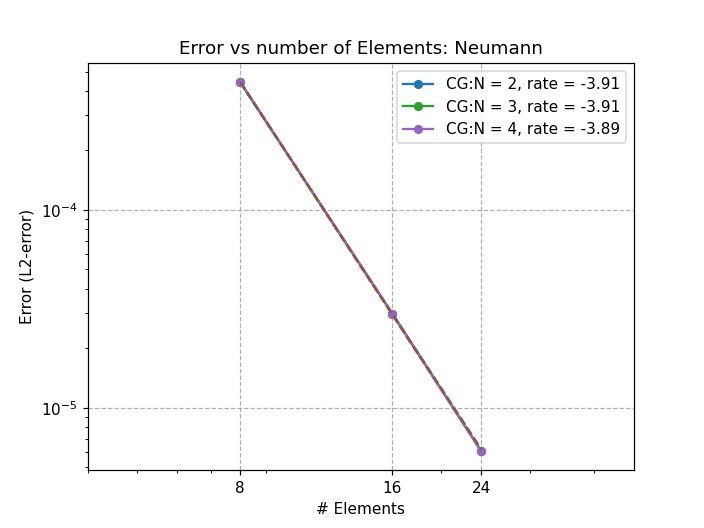

In [5]:
%matplotlib notebook
%pylab

figure(2)

orders = array([2,3,4])

for i,o in enumerate(orders):
    
    e2 = df.loc[idx['Diffusion','CG','inexact',:,:],'2-norm'].values
    
    # DG exact 
    if(o >= 4):
        p = polyfit(log(Nv[:2]), log(e2.astype(float)[:2]), 1)
    else:
        p = polyfit(log(Nv[:]), log(e2.astype(float)[:]), 1)

    loglog(Nv, e2, '.-',markersize = 10, label = 'CG:N = {}, rate = {:.2f}'.format(o,p[0]))
    loglog(Nv, exp(polyval(p,log(Nv))), '--')
    
set_xticks(Nv)
xlabel('# Elements')
ylabel('Error (L2-error)')
title('Error vs number of Elements: Neumann')

grid(axis='both',linestyle='--')
legend()
show()   